In [4]:
import pandas as pd

# Load Good units
df_loaded = pd.read_pickle(r"Q:\sachuriga\CR_CA1_paper/tables/good_units_with_tsnLabels_withphase.pkl")
df_loaded 

,spike_times,unit_name,sd_ratio,sync_spike_8.1,presence_ratio,cluster_id.30,half_width,l_ratio.1,recovery_slope.1,cluster_id.19,...,PS_slope2,PS_phi2,PS_p3,PS_cr3,PS_slope3,PS_phi3,prefered_phase,min_phase,theta_index,prefered_phase_smooth
0,"[79.80586666666666, 82.36903333333333, 82.5270...",5,1.911421,0.0,1.000000,0.0,0.000113,5.665784e-03,-135826.081350,0.0,...,-0.010004,0.490979,0.500912,-0.243736,-0.010004,0.311383,180.000000,2.0,4.713279,0.5
1,"[355.5495666666667, 494.1717, 555.7439, 658.68...",6,2.804665,0.0,0.473684,1.0,0.000097,8.633910e-10,-189691.323121,1.0,...,NaN,NaN,0.698130,0.202794,-0.010004,4.141374,180.000000,1.0,8.389182,0.5
2,"[85.13216666666666, 85.2458, 85.54376666666667...",14,2.514760,0.0,1.000000,2.0,0.000143,2.147104e-05,-130640.317634,2.0,...,-0.415697,5.219217,0.087518,-0.236910,-0.499996,2.454797,180.000000,3.0,7.317134,0.5
3,"[64.58993333333333, 64.67256666666667, 64.6925...",17,1.383377,0.0,1.000000,3.0,0.000177,7.603359e-10,-43784.124843,3.0,...,-0.054252,4.108339,0.477190,-0.058731,-0.480777,5.173381,259.500000,6.0,5.978596,254.5
4,"[80.59643333333334, 80.6237, 80.6897, 80.7649,...",20,1.409312,0.0,1.000000,4.0,0.000150,9.093921e-04,-114143.425971,4.0,...,-0.272335,0.774874,0.939902,0.005696,-0.065916,6.060456,159.372727,4.0,9.540078,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632,"[49.6793, 49.982733333333336, 59.4068, 59.9050...",57,1.099195,0.0,0.951220,37.0,0.000193,2.283637e-04,-135012.562402,37.0,...,-0.499996,1.040786,0.380497,-0.060065,-0.059571,0.702362,159.437729,5.0,10.389358,2.5
1633,"[53.8643, 53.8726, 54.225033333333336, 54.2430...",58,1.326882,0.0,1.000000,38.0,0.000103,9.846390e-11,-151900.470747,38.0,...,-0.071433,5.651796,0.413871,-0.025412,-0.010004,5.903992,245.000000,14.0,10.590071,242.5
1634,"[53.4344, 53.44533333333333, 81.99256666666666...",59,1.192254,0.0,1.000000,39.0,0.000113,3.331845e-10,-110412.581312,39.0,...,-0.220803,5.808744,0.291660,0.071394,-0.499996,0.554090,187.730366,6.0,9.896974,0.5
1635,"[49.797266666666665, 49.8036, 49.8072666666666...",64,1.134203,0.0,1.000000,40.0,0.000080,6.495784e-13,-58727.597060,40.0,...,-0.377560,0.180265,0.084321,-0.220819,-0.010004,1.975884,69.444444,4.0,9.412576,3.5



Comparison for PS_slope1 (Session A):
Control mean: -0.19 ± 0.02
Experimental mean: -0.11 ± 0.02
One-sided t-test statistic: -2.67, p-value: 0.0092
 KS statistic: 0.00, p-value: 1.0000
KS statistic: 0.38, p-value: 0.0044

Comparison for PS_slope2 (Session A):
Control mean: -0.26 ± 0.02
Experimental mean: -0.19 ± 0.03
One-sided t-test statistic: -1.73, p-value: 0.0878
 KS statistic: 0.00, p-value: 1.0000
KS statistic: 0.24, p-value: 0.1677

Comparison for PS_slope3 (Session A):
Control mean: -0.13 ± 0.02
Experimental mean: -0.12 ± 0.02
One-sided Mann-Whitney U statistic: 808.00, p-value: 0.6993
 KS statistic: 0.12, p-value: 0.5040
KS statistic: 0.14, p-value: 0.7620

Comparison for PS_cr1 (Session A):
Control mean: -0.23 ± 0.02
Experimental mean: -0.22 ± 0.02
One-sided Mann-Whitney U statistic: 858.00, p-value: 0.9455
 KS statistic: 0.10, p-value: 0.5957
KS statistic: 0.10, p-value: 0.9602


C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` v


Comparison for PS_cr2 (Session A):
Control mean: -0.02 ± 0.03
Experimental mean: 0.02 ± 0.02
One-sided Mann-Whitney U statistic: 741.00, p-value: 0.3228
 KS statistic: 0.05, p-value: 0.8656
KS statistic: 0.20, p-value: 0.3546

Comparison for PS_cr3 (Session A):
Control mean: 0.01 ± 0.02
Experimental mean: -0.03 ± 0.01
One-sided t-test statistic: 1.32, p-value: 0.1907
 KS statistic: 0.30, p-value: 0.0214
KS statistic: 0.30, p-value: 0.0427


C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


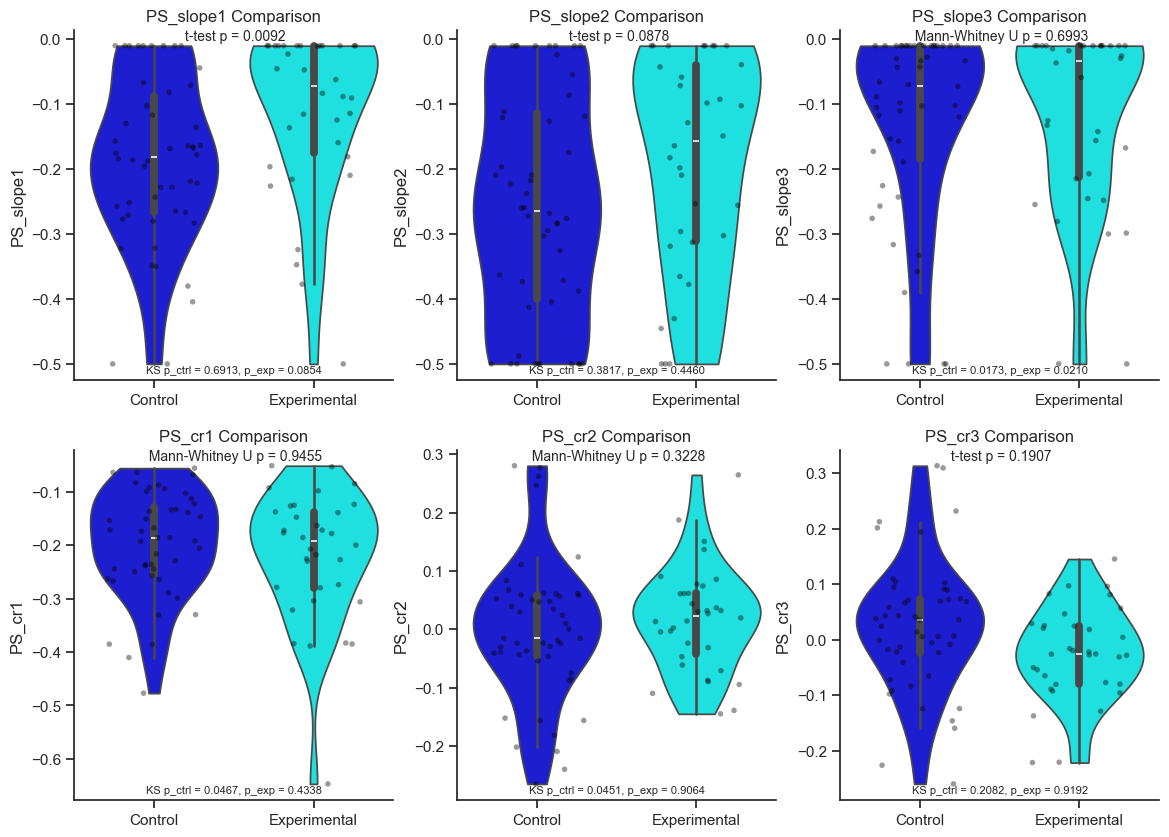

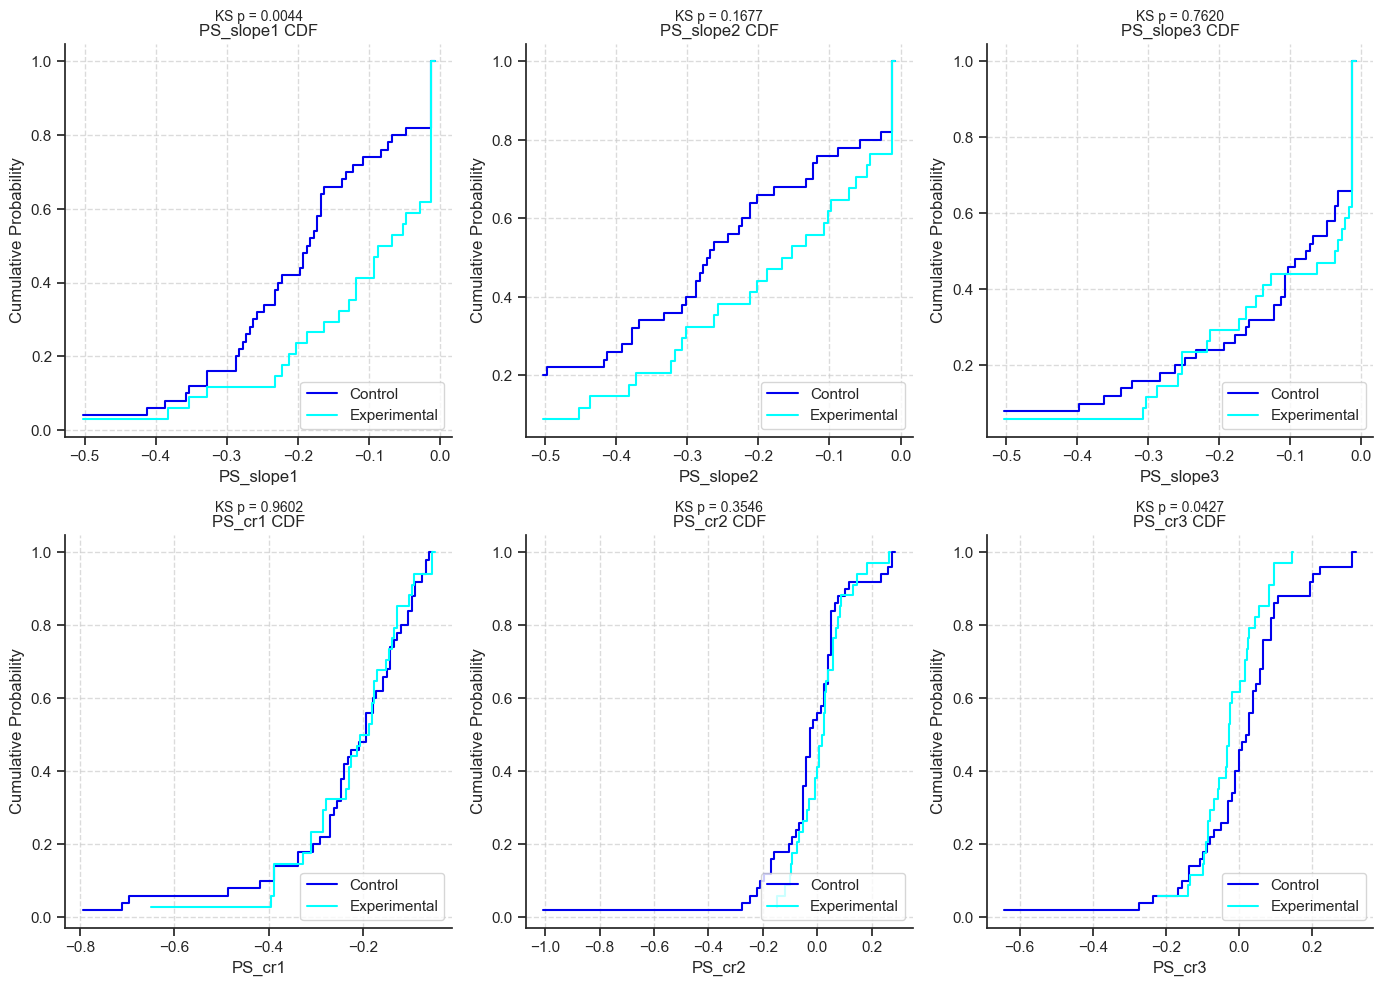


Comparison for PS_slope1 (Session B):
Control mean: -0.17 ± 0.02
Experimental mean: -0.17 ± 0.02
One-sided t-test statistic: -0.07, p-value: 0.9480
 KS statistic: 0.10, p-value: 0.6794
KS statistic: 0.12, p-value: 0.9486

Comparison for PS_slope2 (Session B):
Control mean: -0.26 ± 0.03
Experimental mean: -0.28 ± 0.03
One-sided t-test statistic: 0.46, p-value: 0.6435
 KS statistic: 0.15, p-value: 0.4113
KS statistic: 0.15, p-value: 0.7687

Comparison for PS_slope3 (Session B):
Control mean: -0.12 ± 0.02
Experimental mean: -0.11 ± 0.02
One-sided Mann-Whitney U statistic: 539.00, p-value: 0.6675
 KS statistic: 0.07, p-value: 0.7758
KS statistic: 0.18, p-value: 0.5488

Comparison for PS_cr1 (Session B):
Control mean: -0.17 ± 0.01
Experimental mean: -0.17 ± 0.02
One-sided Mann-Whitney U statistic: 485.00, p-value: 0.2795
 KS statistic: 0.07, p-value: 0.7894
KS statistic: 0.28, p-value: 0.1243

Comparison for PS_cr2 (Session B):
Control mean: -0.00 ± 0.03
Experimental mean: -0.02 ± 0.02
One

C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` v

KS statistic: 0.23, p-value: 0.2721

Comparison for PS_cr3 (Session B):
Control mean: 0.02 ± 0.02
Experimental mean: 0.00 ± 0.02
One-sided t-test statistic: 0.37, p-value: 0.7099
 KS statistic: 0.18, p-value: 0.2872
KS statistic: 0.18, p-value: 0.5618


C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


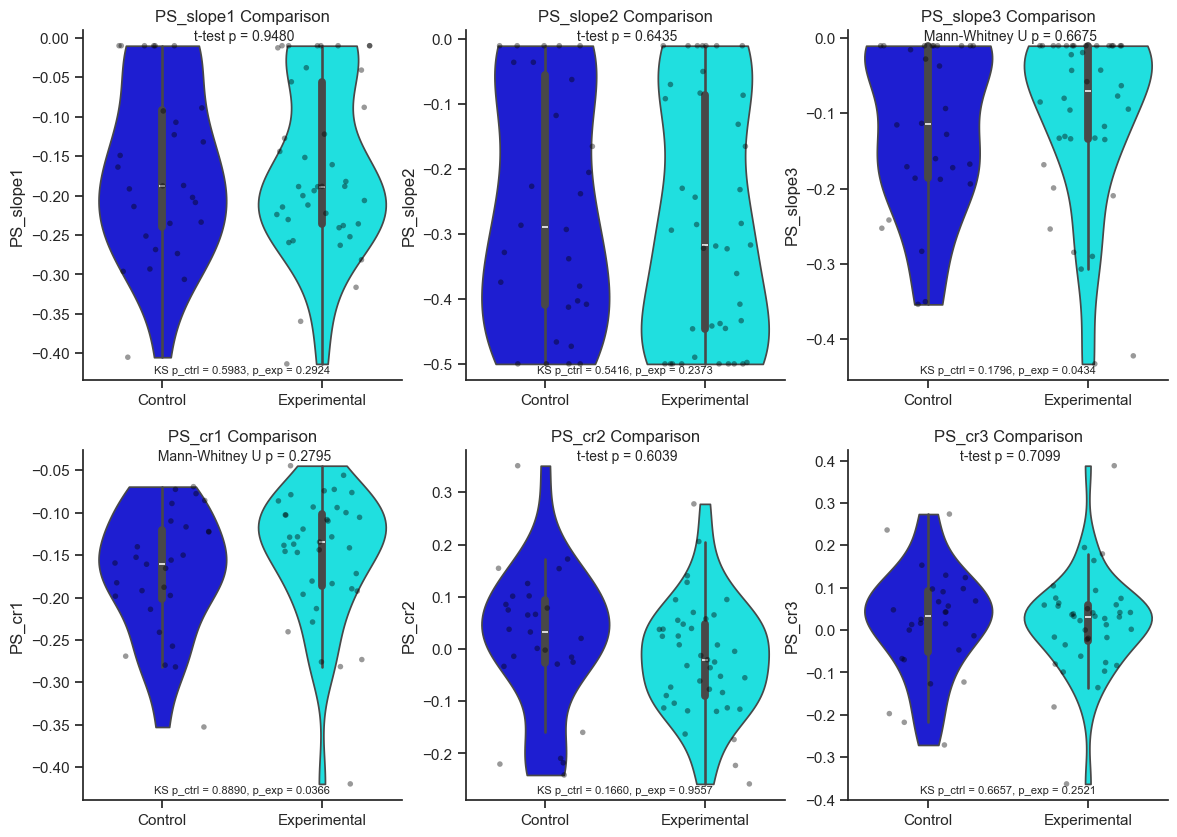

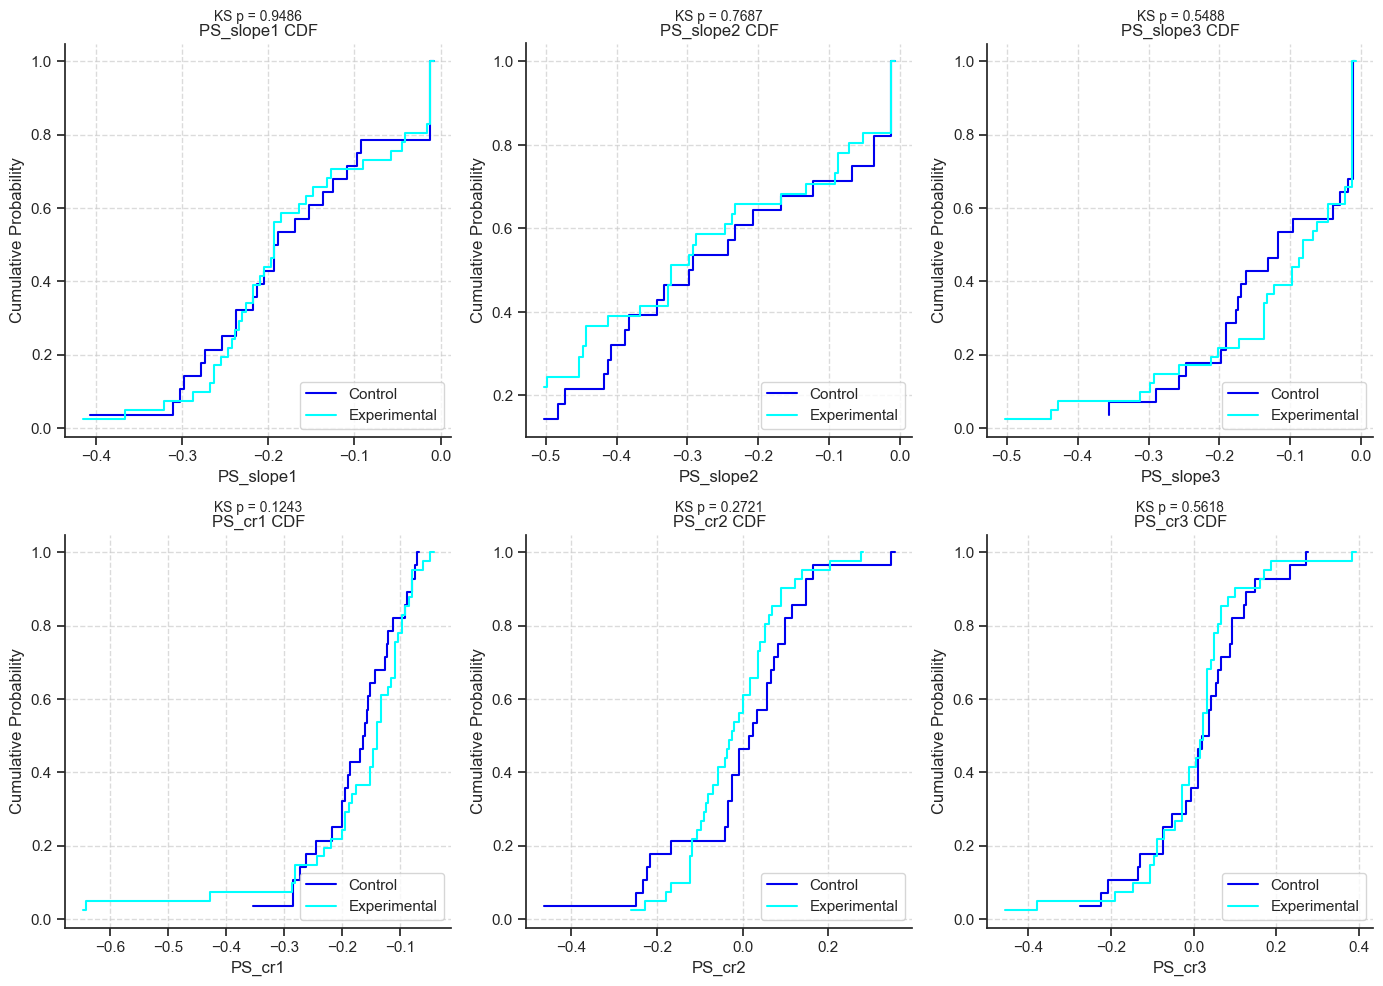


Comparison for PS_slope1 (Session C):
Control mean: -0.19 ± 0.03
Experimental mean: -0.18 ± 0.03
One-sided t-test statistic: -0.32, p-value: 0.7465
 KS statistic: 0.09, p-value: 0.7336
KS statistic: 0.15, p-value: 0.8534

Comparison for PS_slope2 (Session C):
Control mean: -0.31 ± 0.04
Experimental mean: -0.25 ± 0.03
One-sided t-test statistic: -1.26, p-value: 0.2144
 KS statistic: 0.01, p-value: 0.9826
KS statistic: 0.26, p-value: 0.2444

Comparison for PS_slope3 (Session C):
Control mean: -0.16 ± 0.03
Experimental mean: -0.18 ± 0.03
One-sided t-test statistic: 0.47, p-value: 0.6406
 KS statistic: 0.12, p-value: 0.6066
KS statistic: 0.12, p-value: 0.9663

Comparison for PS_cr1 (Session C):
Control mean: -0.19 ± 0.03
Experimental mean: -0.18 ± 0.02
One-sided Mann-Whitney U statistic: 440.00, p-value: 0.9761
 KS statistic: 0.11, p-value: 0.6368
KS statistic: 0.11, p-value: 0.9789

Comparison for PS_cr2 (Session C):
Control mean: 0.01 ± 0.03
Experimental mean: 0.05 ± 0.02
One-sided Mann

C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` v

KS statistic: 0.25, p-value: 0.2672

Comparison for PS_cr3 (Session C):
Control mean: 0.03 ± 0.02
Experimental mean: -0.01 ± 0.02
One-sided t-test statistic: 1.57, p-value: 0.1226
 KS statistic: 0.31, p-value: 0.0448
KS statistic: 0.31, p-value: 0.0897


C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


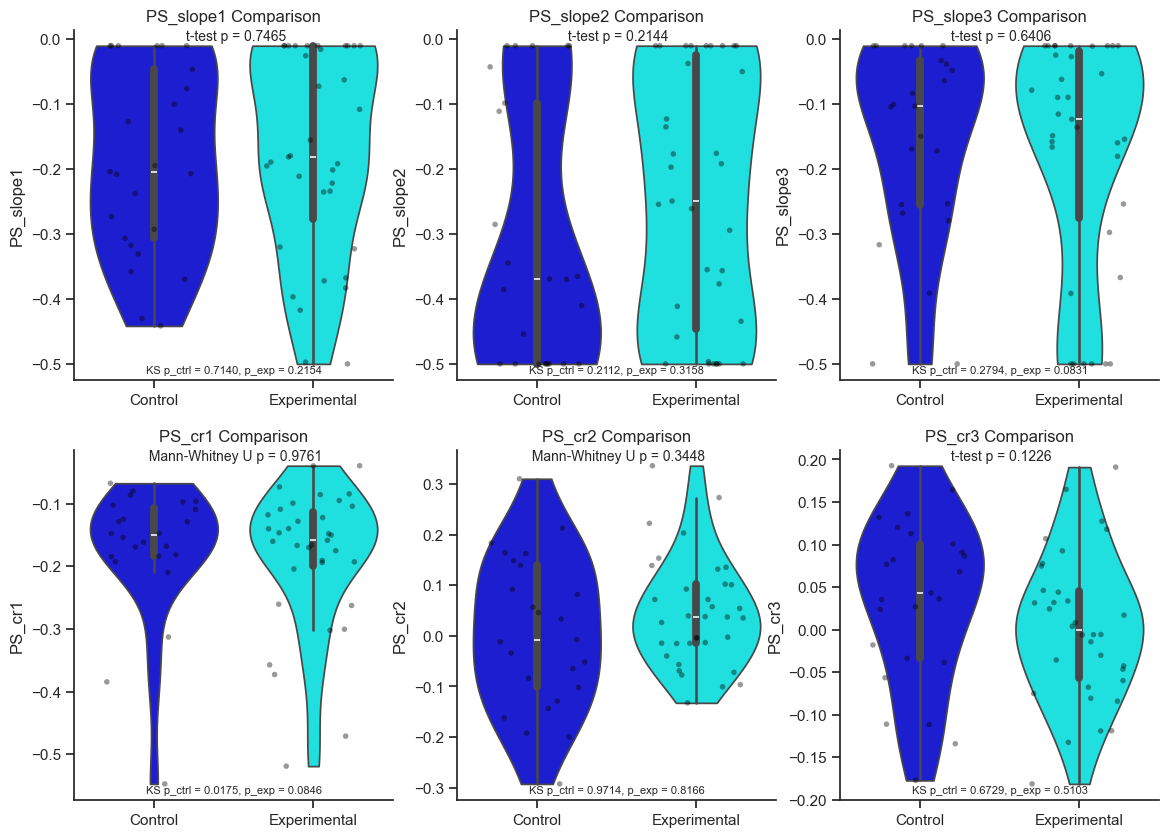

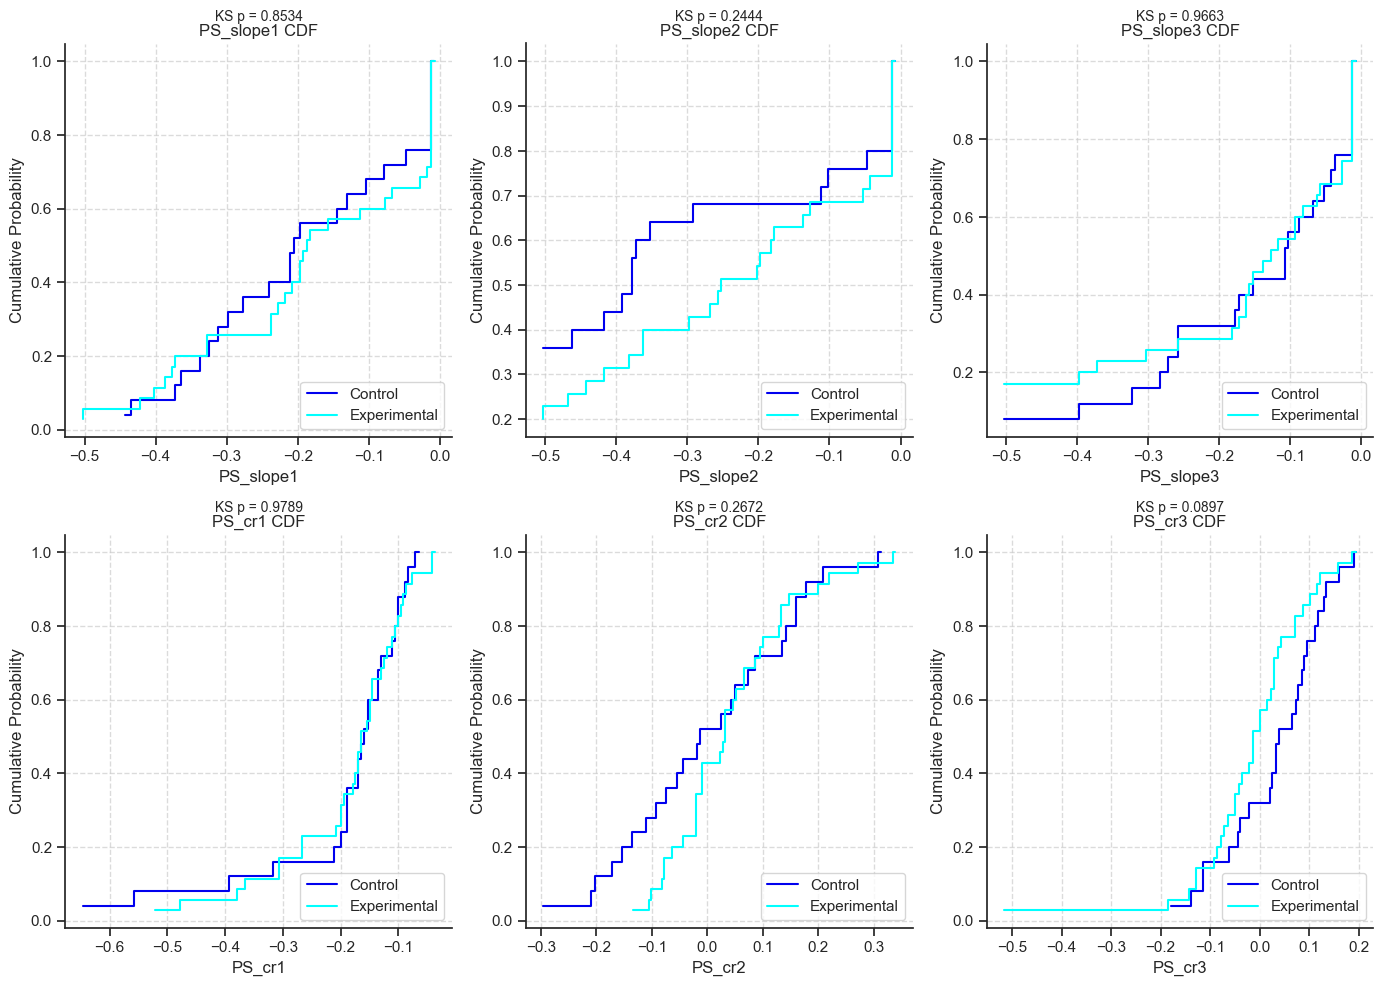


Comparison for PS_slope1 (Session Total):
Control mean: -0.18 ± 0.01
Experimental mean: -0.15 ± 0.01
One-sided Mann-Whitney U statistic: 4895.00, p-value: 0.0852
 KS statistic: 0.02, p-value: 0.9269
KS statistic: 0.15, p-value: 0.1627

Comparison for PS_slope2 (Session Total):
Control mean: -0.27 ± 0.02
Experimental mean: -0.24 ± 0.02
One-sided t-test statistic: -1.13, p-value: 0.2592
 KS statistic: 0.01, p-value: 0.9735
KS statistic: 0.11, p-value: 0.4476

Comparison for PS_slope3 (Session Total):
Control mean: -0.13 ± 0.01
Experimental mean: -0.14 ± 0.01
One-sided Mann-Whitney U statistic: 5576.50, p-value: 0.8424
 KS statistic: 0.05, p-value: 0.7269
KS statistic: 0.07, p-value: 0.9296

Comparison for PS_cr1 (Session Total):
Control mean: -0.21 ± 0.01
Experimental mean: -0.19 ± 0.01


C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


One-sided Mann-Whitney U statistic: 5296.00, p-value: 0.4123
 KS statistic: 0.03, p-value: 0.8541
KS statistic: 0.11, p-value: 0.4544

Comparison for PS_cr2 (Session Total):
Control mean: -0.01 ± 0.02
Experimental mean: 0.01 ± 0.01
One-sided Mann-Whitney U statistic: 5457.00, p-value: 0.6444
 KS statistic: 0.06, p-value: 0.6245
KS statistic: 0.15, p-value: 0.1661

Comparison for PS_cr3 (Session Total):
Control mean: 0.02 ± 0.01
Experimental mean: -0.01 ± 0.01
One-sided t-test statistic: 1.68, p-value: 0.0937
 KS statistic: 0.21, p-value: 0.0090
KS statistic: 0.21, p-value: 0.0179


C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_20224\1456655014.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artis

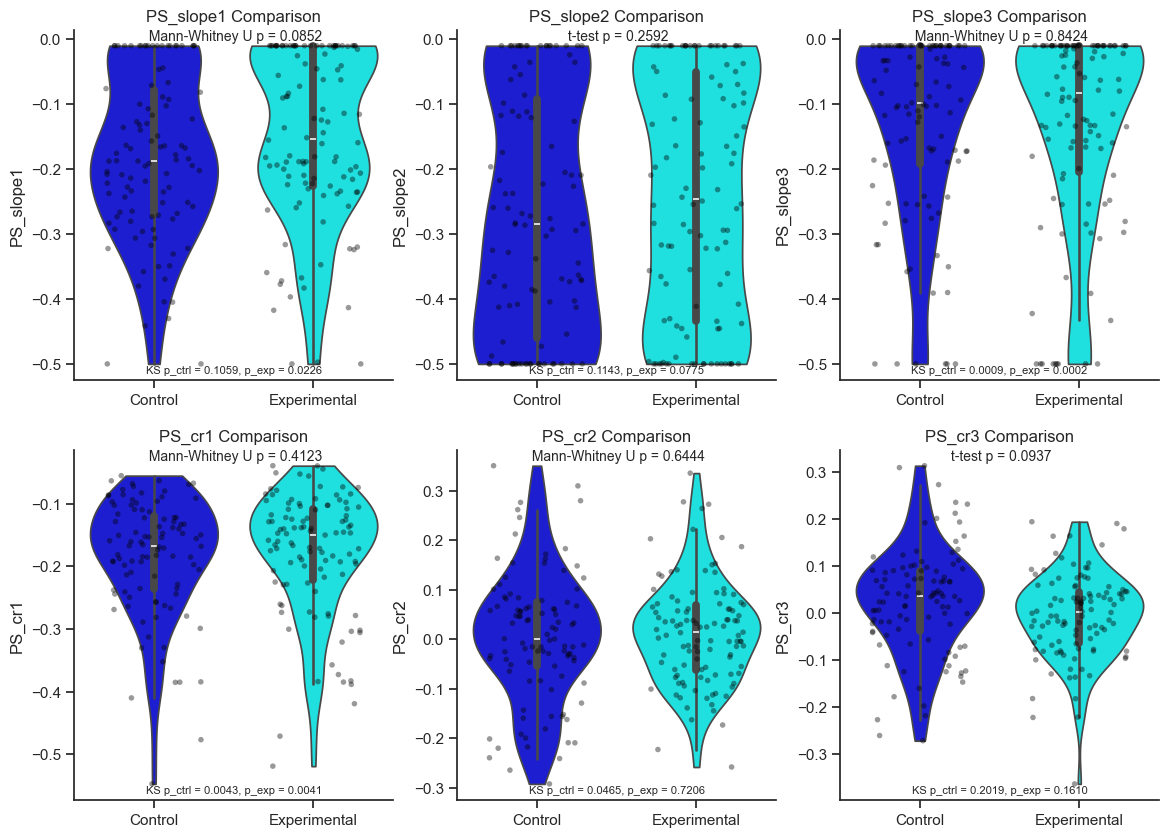

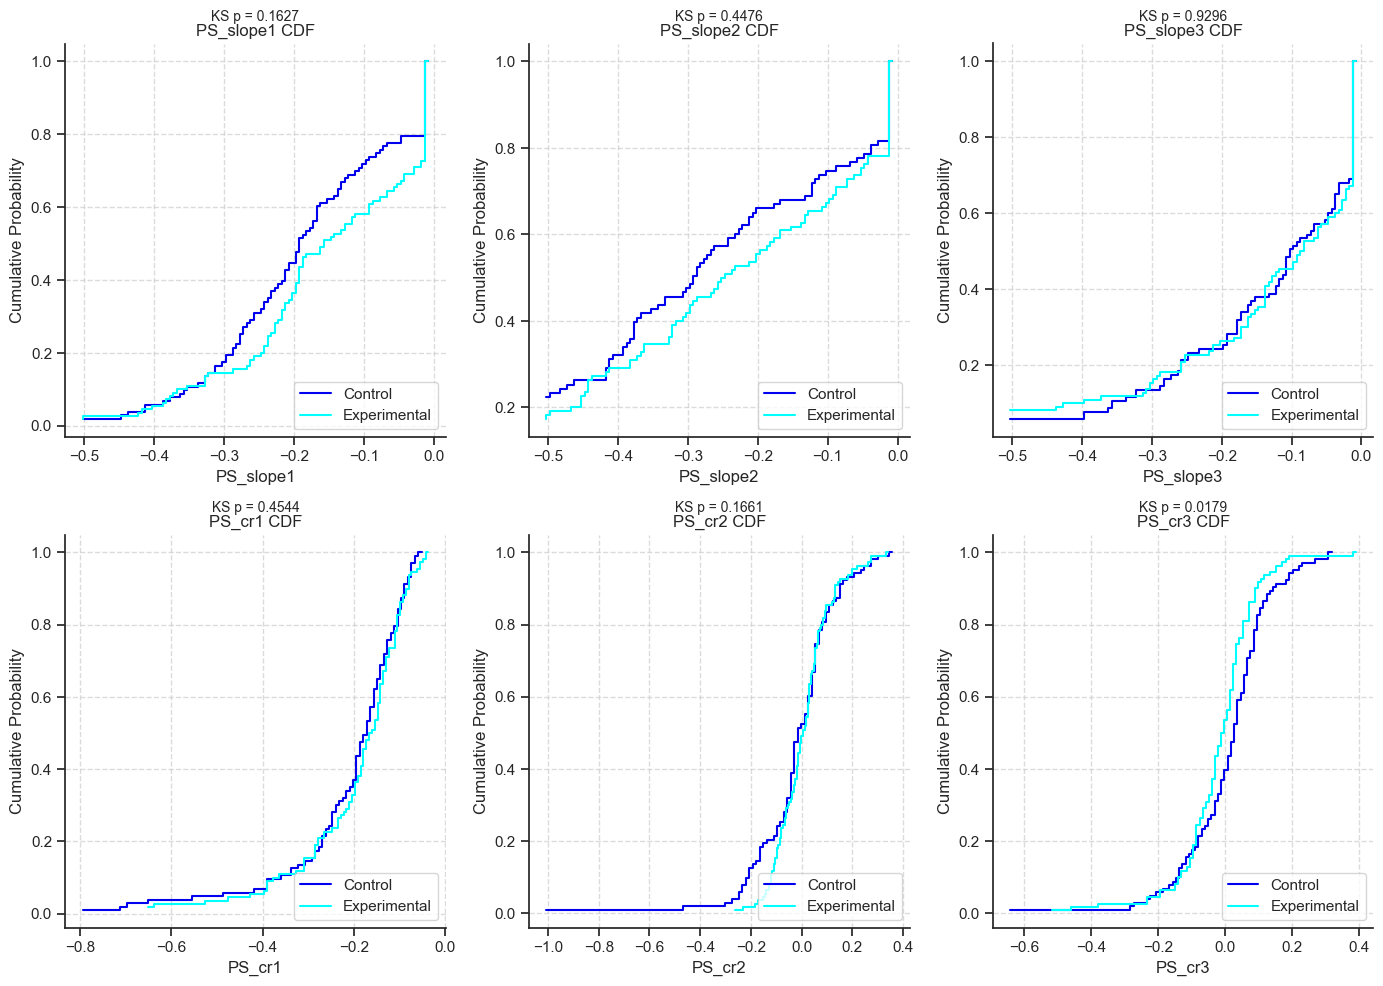

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Load Good units
df_loaded = pd.read_pickle(r"Q:\sachuriga\CR_CA1_paper/tables/good_units_with_tsnLabels_withphase.pkl")
df_good = df_loaded[df_loaded['unit_quality'] == "good"]
df_py = df_good[(df_good['cell_type'] == "pyramidal")& (df_good['theta_index'] > 5)]

df_phase_precessing =  df_py[(df_py['PS_p1'] < 0.05) & (df_py['PS_cr1'] < 0) ]  
funct = [""]

for functional_plot in funct:
    df = df_phase_precessing

    base_folder = r"Q:/sachuriga/CR_CA1_paper/Results/cell_type"

    control_ids = ['65165', '65091', '63383', '66539', '65622']
    exp_ids = ['65588', '63385', '66538', '66537', '66922']

    session = ["A", "B", "C", "Total"]

    for session in session:
        if session == "Total":
            df_a = df
        else:
            df_a = df[df['session'] == session]

        control_df = df_a[df_a['animal_id'].isin(control_ids)]
        exp_df = df_a[df_a['animal_id'].isin(exp_ids)]

        sns.set_theme(style="ticks")

        metrics = ['PS_slope1', 'PS_slope2', 'PS_slope3','PS_cr1','PS_cr2','PS_cr3']

        fig_violin, axes_violin = plt.subplots(2, 3, figsize=(14, 10))
        axes_violin = axes_violin.flatten()

        fig_cdf, axes_cdf = plt.subplots(2, 3, figsize=(14, 10))
        axes_cdf = axes_cdf.flatten()

        control_color = sns.color_palette(palette='flag')[-1]
        exp_color = "cyan"

        for idx, metric in enumerate(metrics):
            control_values = control_df[metric].dropna()
            exp_values = exp_df[metric].dropna()

            if len(control_values) > 0 and len(exp_values) > 0:
                control_mean = control_values.mean()
                exp_mean = exp_values.mean()
                control_sem = control_values.sem()
                exp_sem = exp_values.sem()

                print(f"\nComparison for {metric} (Session {session}):")
                print(f"Control mean: {control_mean:.2f} ± {control_sem:.2f}")
                print(f"Experimental mean: {exp_mean:.2f} ± {exp_sem:.2f}")

                # Statistical tests for violin plot (one-sided, control > exp)
                control_ks_stat, control_ks_p = stats.kstest(control_values, 'norm', 
                                                            args=(control_mean, control_values.std()))
                exp_ks_stat, exp_ks_p = stats.kstest(exp_values, 'norm', 
                                                    args=(exp_mean, exp_values.std()))
                normal = control_ks_p > 0.05 and exp_ks_p > 0.05

                levene_stat, levene_p = stats.levene(control_values, exp_values)
                homoscedastic = levene_p > 0.05

                if normal and homoscedastic:
                    t_stat, p_val = stats.ttest_ind(control_values, exp_values, equal_var=True)
                    test_name = " t-test"
                    print(f"One-sided t-test statistic: {t_stat:.2f}, p-value: {p_val:.4f}")
                else:
                    u_stat, p_val = stats.mannwhitneyu(control_values, exp_values)
                    test_name = " Mann-Whitney U"
                    print(f"One-sided Mann-Whitney U statistic: {u_stat:.2f}, p-value: {p_val:.4f}")

                # Two-sample KS test (one-sided, control > exp)
                ks_stat, ks_p = stats.ks_2samp(control_values, exp_values, alternative='less')
                print(f" KS statistic: {ks_stat:.2f}, p-value: {ks_p:.4f}")

                # Two-sample KS test for CDF
                ks_stat, ks_p = stats.ks_2samp(control_values, exp_values)
                print(f"KS statistic: {ks_stat:.2f}, p-value: {ks_p:.4f}")

                # Violin Plot
                plot_df = pd.DataFrame({
                    'value': pd.concat([control_values, exp_values]),
                    'group': ['Control'] * len(control_values) + ['Experimental'] * len(exp_values)
                })
                all_values = plot_df['value']
                mean_val = all_values.mean()
                std_val = all_values.std()
                plot_df_filtered = plot_df[(plot_df['value'] >= mean_val - 3 * std_val) & 
                                           (plot_df['value'] <= mean_val + 3 * std_val)]

                sns.violinplot(
                    data=plot_df_filtered, x='group', y='value', ax=axes_violin[idx],
                    palette={"Control": control_color, "Experimental": exp_color}, width=0.8, cut=0
                )
                for patch in axes_violin[idx].collections:
                    patch.set_alpha(1)

                sns.stripplot(
                    data=plot_df_filtered, x='group', y='value', ax=axes_violin[idx], size=4,
                    hue='group', palette={"Control": "black", "Experimental": "black"},
                    alpha=0.4, jitter=0.3, legend=False
                )

                axes_violin[idx].set_title(f'{metric} Comparison')
                axes_violin[idx].set_ylabel(metric)
                axes_violin[idx].set_xlabel('')
                axes_violin[idx].yaxis.grid(False)
                axes_violin[idx].text(0.5, 0.04, f'KS p_ctrl = {control_ks_p:.4f}, p_exp = {exp_ks_p:.4f}', 
                                     ha='center', va='top', transform=axes_violin[idx].transAxes, fontsize=8)
                axes_violin[idx].text(0.5, 1.002, f'{test_name} p = {p_val:.4f}', 
                                     ha='center', va='top', transform=axes_violin[idx].transAxes, fontsize=10)
                axes_violin[idx].spines['top'].set_visible(False)
                axes_violin[idx].spines['right'].set_visible(False)
                axes_violin[idx].spines['bottom'].set_visible(True)
                axes_violin[idx].spines['left'].set_visible(True)

                # CDF Plot
                control_cfreq = stats.cumfreq(control_values, numbins=100)
                exp_cfreq = stats.cumfreq(exp_values, numbins=100)

                control_cdf = control_cfreq.cumcount / control_cfreq.cumcount[-1]
                exp_cdf = exp_cfreq.cumcount / exp_cfreq.cumcount[-1]

                num_bins = len(control_cfreq.cumcount)
                control_x = control_cfreq.lowerlimit + np.linspace(0, control_cfreq.binsize * num_bins, num_bins)
                num_bins = len(exp_cfreq.cumcount)
                exp_x = exp_cfreq.lowerlimit + np.linspace(0, exp_cfreq.binsize * num_bins, num_bins)

                axes_cdf[idx].step(control_x, control_cdf, label='Control', color=control_color, linewidth=1.5)
                axes_cdf[idx].step(exp_x, exp_cdf, label='Experimental', color=exp_color, linewidth=1.5)


                axes_cdf[idx].set_title(f'{metric} CDF')
                axes_cdf[idx].set_xlabel(metric)
                axes_cdf[idx].set_ylabel('Cumulative Probability')
                axes_cdf[idx].legend(loc='lower right')
                axes_cdf[idx].grid(True, linestyle='--', alpha=0.7)
                axes_cdf[idx].text(0.5, 1.05, f'KS p = {ks_p:.4f}', 
                                  ha='center', va='bottom', transform=axes_cdf[idx].transAxes, fontsize=10)
                axes_cdf[idx].spines['top'].set_visible(False)
                axes_cdf[idx].spines['right'].set_visible(False)

        fig_violin.savefig(fr'{base_folder}/{session}_waveforms_pyramidal_{functional_plot}.eps', format='eps', bbox_inches='tight')
        fig_violin.savefig(fr'{base_folder}/{session}_waveforms_pyramidal_{functional_plot}.png', format='png', bbox_inches='tight')

        fig_cdf.savefig(fr'{base_folder}/{session}_waveforms_pyramidal_{functional_plot}_cdf.eps', format='eps', bbox_inches='tight')
        fig_cdf.savefig(fr'{base_folder}/{session}_waveforms_pyramidal_{functional_plot}_cdf.png', format='png', bbox_inches='tight')

        plt.tight_layout()
        plt.show()

In [8]:
import pandas as pd

# Load Good units
df_loaded = pd.read_pickle(r"Q:\sachuriga\CR_CA1_paper/tables/good_units_with_tsnLabels_withphase.pkl")

df_good = df_loaded[df_loaded['unit_quality'] == "good"]
df_py = df_good[(df_good['cell_type'] == "pyramidal")]

df_phase_precessing =  df_py[(df_py['PS_p1'] < 0.05) & (df_py['PS_cr1'] < 0) &(df_good['theta_index'] > 5)]  
funct = [""]

# Define control and experimental animal IDs
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

# Sessions to analyze
sessions = ["A", "B", "C", "Total"]

# Calculate and print ratios for each session
for session in sessions:
    if session == "Total":
        df_py_session = df_py
        df_phase_session = df_phase_precessing
    else:
        df_py_session = df_py[df_py['session'] == session]
        df_phase_session = df_phase_precessing[df_phase_precessing['session'] == session]

    # Split into control and experimental groups
    control_py = df_py_session[df_py_session['animal_id'].isin(control_ids)]
    exp_py = df_py_session[df_py_session['animal_id'].isin(exp_ids)]
    control_phase = df_phase_session[df_phase_session['animal_id'].isin(control_ids)]
    exp_phase = df_phase_session[df_phase_session['animal_id'].isin(exp_ids)]

    # Calculate ratios
    control_ratio = len(control_phase) / len(control_py) if len(control_py) > 0 else 0
    exp_ratio = len(exp_phase) / len(exp_py) if len(exp_py) > 0 else 0

    # Print results
    print(f"\nSession: {session}")
    print(f"Control - Pyramidal cells: {len(control_py)}, Phase precessing cells: {len(control_phase)}, Ratio: {control_ratio:.4f}")
    print(f"Experimental - Pyramidal cells: {len(exp_py)}, Phase precessing cells: {len(exp_phase)}, Ratio: {exp_ratio:.4f}")


Session: A
Control - Pyramidal cells: 268, Phase precessing cells: 50, Ratio: 0.1866
Experimental - Pyramidal cells: 222, Phase precessing cells: 34, Ratio: 0.1532

Session: B
Control - Pyramidal cells: 153, Phase precessing cells: 28, Ratio: 0.1830
Experimental - Pyramidal cells: 205, Phase precessing cells: 41, Ratio: 0.2000

Session: C
Control - Pyramidal cells: 135, Phase precessing cells: 25, Ratio: 0.1852
Experimental - Pyramidal cells: 192, Phase precessing cells: 35, Ratio: 0.1823

Session: Total
Control - Pyramidal cells: 556, Phase precessing cells: 103, Ratio: 0.1853
Experimental - Pyramidal cells: 619, Phase precessing cells: 110, Ratio: 0.1777


C:\Users\sachur\AppData\Local\Temp\ipykernel_26688\1862681148.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_phase_precessing =  df_py[(df_py['PS_p1'] < 0.05) & (df_py['PS_cr1'] < 0) &(df_good['theta_index'] > 5)]
